<a name="top"></a>

---

**Sections:**  ●  [Top](#top)  ●  [The Data](#data)  ●  [Feature Engineering](#features)  ●  [Investigating Correlation](#correlation)   ●  [Lag Features](#lag_features)   ●  [Splitting](#splitting)   ●  [The Model](#model)   ●  [Results with Traditional Split](#traditional_results)   ●  [Using Cross-Validation](#cross_validation)   ●  [Making Future Predictions](#future_predictions)  

---


<center><img src = "http://www.evanmarie.com/content/files/notebook_images/xgboost_banner.png" width = 900></center>


<font size =  4>

**Evan Marie online**: 
[EvanMarie@Proton.me](mailto:evanmarie@proton.me)  |  [Linked In](https://www.linkedin.com/in/evanmarie/)  |  [GitHub](https://github.com/EvanMarie)  |  [Hugging Face](https://huggingface.co/EvanMarie)  |  [Mastadon](https://sigmoid.social/@EvanMarie)  |
[Jovian.ai](https://jovian.ai/evanmarie)  |  [TikTok](https://www.tiktok.com/@evanmarie_123)  |  [CodeWars](https://www.codewars.com/users/EvanMarie)  |  Discord ⇨ ✨ EvanMarie ✨#6114

In [3]:
from helpers import *
import_all()
from xgboost import XGBRegressor
%matplotlib inline
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

<a name="data"></a>

---

**Sections:**  ●  [Top](#top)  ●  [The Data](#data)  ●  [Feature Engineering](#features)  ●  [Investigating Correlation](#correlation)   ●  [Lag Features](#lag_features)   ●  [Splitting](#splitting)   ●  [The Model](#model)   ●  [Results with Traditional Split](#traditional_results)   ●  [Using Cross-Validation](#cross_validation)   ●  [Making Future Predictions](#future_predictions)  

---

<span style = 'background-color: purple; padding: 5px 5px 3px 5px; line-height: 1.5; color:white;border-radius: 3px;'><font size = 4>**The Data**</font></span>
* This data is an excerpt from a [**Kaggle maintained and regularly update dataset collection**](https://www.kaggle.com/datasets/albertovidalrod/electricity-consumption-uk-20092022?select=historic_demand_2009_2022_noNaN.csv)
* The dataset reflects the energy consumption as reported by the National Grid ESO, Great Britain's electricity system operator
* Consumption is recorded twice an hour
* The data covers January 1, 2009 to December 31, 2022

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Importing Data**
	

In [45]:
data = pd.read_csv('uk_power_consumption.csv', parse_dates = ['settlement_date'])
data = data[['settlement_date', 'tsd', 'is_holiday']]
data.columns = ['datetime', 'consumption', 'holiday']
data = data.set_index('datetime', drop=True)


head_tail_horz(data, 5, "UK Power Consumption Data", intraday = True)

,consumption,holiday
datetime,,
2009-01-01 00:00:00,"38,704",1
2009-01-01 00:30:00,"38,964",1
2009-01-01 01:00:00,"38,651",1
2009-01-01 01:30:00,"37,775",1
2009-01-01 02:00:00,"37,298",1
,consumption,holiday
datetime,,
2022-12-31 21:30:00,"25,634",0
2022-12-31 22:00:00,"24,788",0


In [102]:
def timeseries_overview(df, main_col):
	index_col = ['number of records', 'number of columns', 
				 'missing values', 'columns', 'start date',
				'end date', 'main column min', 'main column max']
	
	num_records = df.shape[0]
	num_cols = df.shape[1]
	missing_values = df.isna().sum().sum()
	columns = ', '.join(list(df.columns))
	start_date = min(df.index).strftime('%m/%d/%Y')
	end_date = max(df.index).strftime('%m/%d/%Y')
	main_min = min(df[main_col])
	main_max = max(df[main_col])
	
	values = [num_records, num_cols, missing_values, 
			  columns, start_date, end_date, main_min, main_max]
	
	overview = pd.concat([pd.Series(index_col), pd.Series(values)], axis = 1)
	overview.columns = ['aspects', 'information']
	overview.set_index('aspects')
	
	styling = {'information': [{'selector': '',
							  'props': [('font-size', '15px'),
									('padding-right', '15px'),
									('padding-left', '35px')]}],
			   'aspects': [{'selector': '',
						 'props': [('font-weight', 'bold'),
								   ('font-size', '15px'),
								   ('padding-right', '15px'),
								   ('padding-left', '15px')]}]}
	
	pretty('Initial DataFrame Overview', fontsize=4)
	
	return overview.style\
				   .hide(axis='index')\
				   .set_table_styles(styling)\
				   .format(precision=0, thousands=",")

In [103]:
timeseries_overview(data, 'consumption')

aspects,information
number of records,"244,676"
number of columns,2
missing values,0
columns,"consumption, holiday"
start date,01/01/2009
end date,12/31/2022
main column min,"16,629"
main column max,"60,147"


<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Initial Plotting**
	

In [104]:
colors = sns.color_palette('husl', 11)
colors

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.8836443049112893, 0.5240073524369634, 0.19569304285113343),
 (0.710130687316902, 0.6046852192663268, 0.19426060163712158),
 (0.5432776721247529, 0.6540981095185215, 0.19324494273892204),
 (0.19592059105779686, 0.6981620017487838, 0.3452219818913641),
 (0.2067117296964458, 0.6829103404254792, 0.5829988925822328),
 (0.21420912437215422, 0.6714963557258681, 0.6986206664203177),
 (0.22537170008202412, 0.6531400148480775, 0.841007805313343),
 (0.5596943802099308, 0.5764402169887779, 0.9583930713150347),
 (0.8578978803740231, 0.44058452715322166, 0.957819659566579),
 (0.9628653850704806, 0.4025928454059796, 0.7779310354076443)]

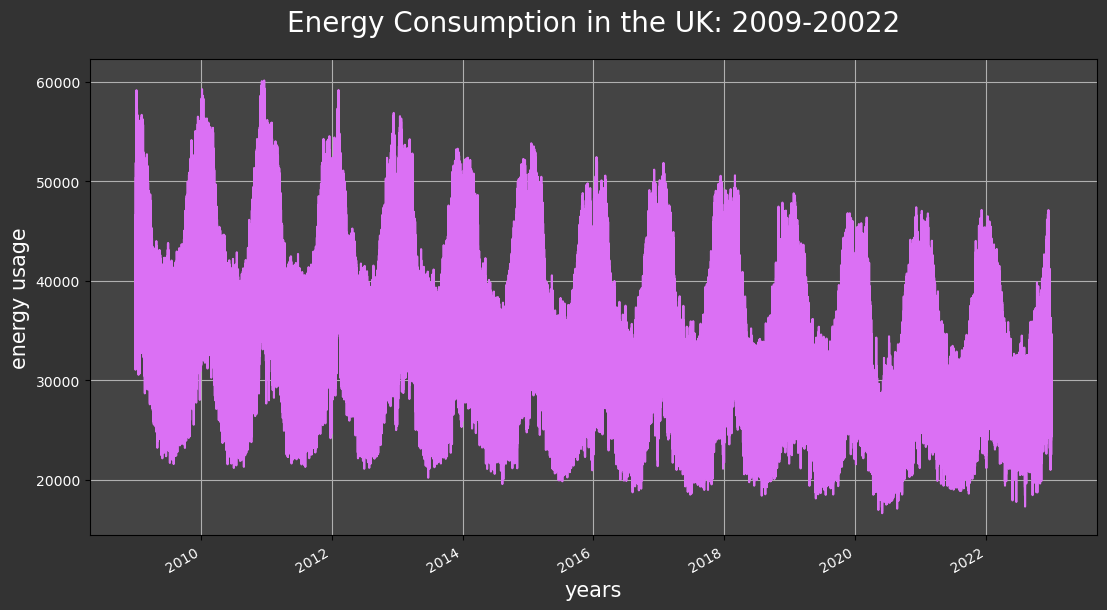

In [115]:
fig = plt.figure(facecolor = '#333333', figsize = (13,7));
ax = plt.axes();
ax.set_facecolor('#444444')
data['consumption'].plot(color = colors[9], 
		  ax = ax);
ax.grid()
plt.xlabel('years', color = 'white', fontsize = 15)
plt.ylabel('energy usage', color = 'white', fontsize = 15)
plt.xticks(color='white'); plt.yticks(color='white');
plt.title('Energy Consumption in the UK: 2009-20022', fontsize = 20, 
		  pad = 20, color = 'white');

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Looking at a Single Week of Data**

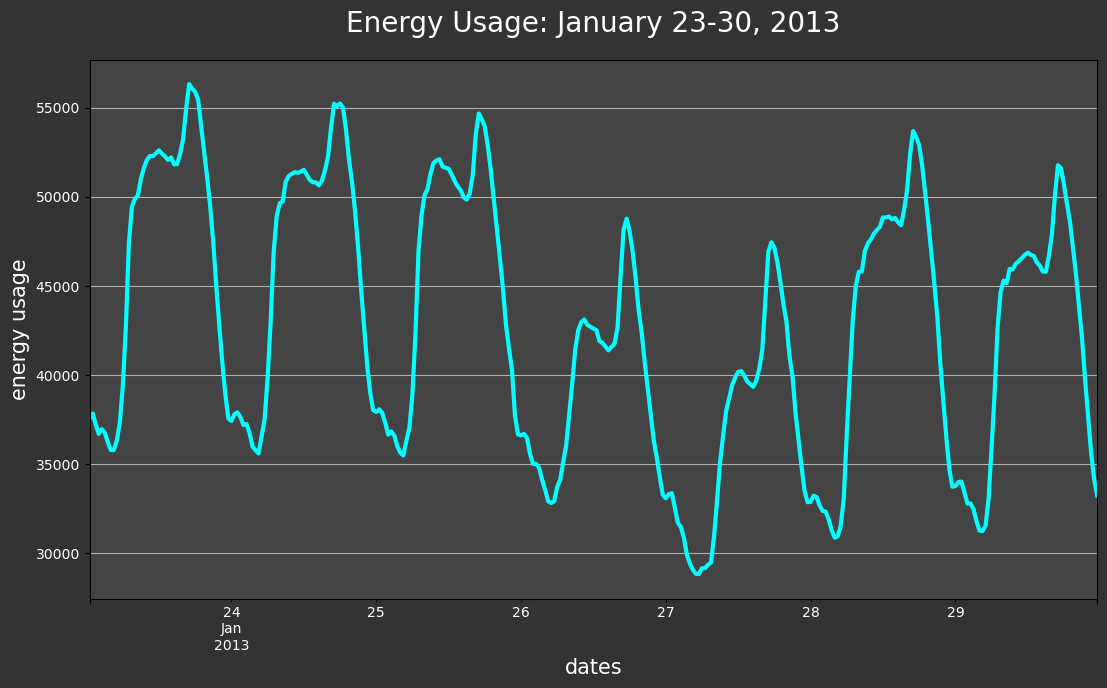

In [116]:
fig, ax = plt.subplots(figsize = (13, 7), facecolor = '#333333')
ax.set_facecolor('#444444')
data['consumption'].iloc[(data.index > '01-23-2013') \
		  & (data.index < '01-30-2013')].plot(ax = ax, linewidth = 3, color = 'cyan')
ax.grid()
plt.xlabel('dates', color = 'white', fontsize = 15)
plt.ylabel('energy usage', color = 'white', fontsize = 15)
plt.tick_params(labelcolor = 'white', which = 'both')
plt.title('Energy Usage: January 23-30, 2013', fontsize = 20, 
		  pad = 20, color = 'white');
plt.legend().remove()

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Distribution of Energy Use Values**

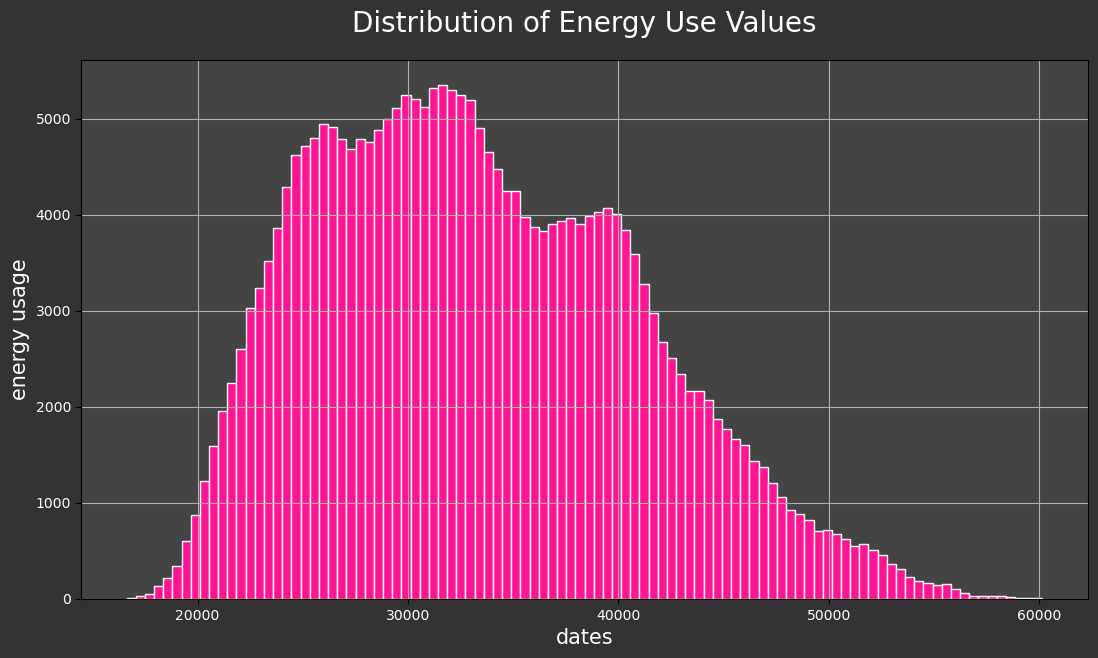

In [120]:
fig, ax = plt.subplots(figsize = (13, 7), facecolor = '#333333')
ax.set_facecolor('#444444')
data['consumption'].plot(kind = 'hist', bins = 100,
				  color = 'deeppink', edgecolor = 'white');
ax.grid()
plt.xlabel('dates', color = 'white', fontsize = 15)
plt.ylabel('energy usage', color = 'white', fontsize = 15)
plt.tick_params(labelcolor = 'white', which = 'both')
plt.title('Distribution of Energy Use Values', 
		  fontsize = 20, pad = 20, color = 'white');
plt.legend().remove()

<a name="features"></a>

---

**Sections:**  ●  [Top](#top)  ●  [The Data](#data)  ●  [Feature Engineering](#features)  ●  [Investigating Correlation](#correlation)   ●  [Lag Features](#lag_features)   ●  [Splitting](#splitting)   ●  [The Model](#model)   ●  [Results with Traditional Split](#traditional_results)   ●  [Using Cross-Validation](#cross_validation)   ●  [Making Future Predictions](#future_predictions)  

---

<span style = 'background-color: purple; padding: 5px 5px 3px 5px; line-height: 1.5; color:white;border-radius: 3px;'><font size = 4>**Feature Engineering**</font></span>

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Time Series DateTime Index Feature Creation**

In [121]:
def featurize_datetime_index(df, daytime = True):
	df = df.copy()
	
	df['hour'] = df.index.hour
	df['weekday'] = df.index.dayofweek
	df['weekday_name'] = df.index.strftime('%A')
	df['month'] = df.index.month
	df['month_name'] = df.index.strftime('%B')
	df['quarter'] = df.index.quarter
	df['year'] = df.index.year
	df['week_of_year'] = df.index.isocalendar().week
	df['day_of_year'] = df.index.dayofyear
	
	if daytime:
		# Add column with category for time of day: 
		# midnight, early_morning, late_morning, afternoon, evening, night 
		def time_of_day(hour):
			if hour >= 0 and hour < 6:
				return 'midnight'
			elif hour >= 6 and hour < 9:
				return 'early_morning'
			elif hour >= 9 and hour < 12:
				return 'late_morning'
			elif hour >= 12 and hour < 15:
				return 'afternoon'
			elif hour >= 15 and hour < 18:
				return 'evening'
			else:
				return 'night'

		df['time_of_day'] = (df['hour'].apply(time_of_day)).astype('category')
		
	df['weekday_name'] = df['weekday_name'].astype('category')
	df['month_name'] = df['month_name'].astype('category')
	
	return df

In [122]:
df = featurize_datetime_index(data.copy())

In [123]:
head_tail_horz(df.sample(10), 5, 'DF with Added Datetime Features (Random Samples)', intraday=True)

,consumption,holiday,hour,weekday,weekday_name,month,month_name,quarter,year,week_of_year,day_of_year,time_of_day
datetime,,,,,,,,,,,,
2019-03-23 18:00:00,"37,097",0,18,5,Saturday,3,March,1,"2,019",12,82,night
2021-10-07 21:00:00,"30,872",0,21,3,Thursday,10,October,4,"2,021",40,280,night
2022-06-20 08:30:00,"30,410",0,8,0,Monday,6,June,2,"2,022",25,171,early_morning
2010-11-15 23:00:00,"36,683",0,23,0,Monday,11,November,4,"2,010",46,319,night
2016-11-06 21:00:00,"35,070",0,21,6,Sunday,11,November,4,"2,016",44,311,night
,consumption,holiday,hour,weekday,weekday_name,month,month_name,quarter,year,week_of_year,day_of_year,time_of_day
datetime,,,,,,,,,,,,
2014-05-08 14:30:00,"39,753",0,14,3,Thursday,5,May,2,"2,014",19,128,afternoon
2011-04-05 12:30:00,"43,494",0,12,1,Tuesday,4,April,2,"2,011",14,95,afternoon


In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 244676 entries, 2009-01-01 00:00:00 to 2022-12-31 23:30:00
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   consumption   244676 non-null  int64   
 1   holiday       244676 non-null  int64   
 2   hour          244676 non-null  int64   
 3   weekday       244676 non-null  int64   
 4   weekday_name  244676 non-null  category
 5   month         244676 non-null  int64   
 6   month_name    244676 non-null  category
 7   quarter       244676 non-null  int64   
 8   year          244676 non-null  int64   
 9   week_of_year  244676 non-null  UInt32  
 10  day_of_year   244676 non-null  int64   
 11  time_of_day   244676 non-null  category
dtypes: UInt32(1), category(3), int64(8)
memory usage: 18.7 MB


<a name="correlation"></a>

---

**Sections:**  ●  [Top](#top)  ●  [The Data](#data)  ●  [Feature Engineering](#features)  ●  [Investigating Correlation](#correlation)   ●  [Lag Features](#lag_features)   ●  [Splitting](#splitting)   ●  [The Model](#model)   ●  [Results with Traditional Split](#traditional_results)   ●  [Using Cross-Validation](#cross_validation)   ●  [Making Future Predictions](#future_predictions)  

---

<span style = 'background-color: purple; padding: 5px 5px 3px 5px; line-height: 1.5; color:white;border-radius: 3px;'><font size = 4>**Investigating Correlation**</font></span>

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Visualize Correlation Between Features and Target**

In [125]:
def boxplot_correlation(df, feature_x, feature_y, order = None, palette = None):
	
	fig, ax = plt.subplots(figsize = (13, 7), facecolor = '#333333')
	ax.set_facecolor('LightGray')
	
	sns.boxplot(data = df, 
				x = feature_x, 
				y = feature_y,
			    order = order,
			    palette = palette)
	
	x_name = str(df[feature_x].name)
	y_name = str(df[feature_y].name)
	
	ax.grid()
	plt.xlabel(x_name, color = 'white', fontsize = 15)
	plt.ylabel(y_name, color = 'white', fontsize = 15)
	plt.xticks(color='white'); plt.yticks(color='white');
	plt.title(f'Feature Correlation: {x_name.capitalize()} - {y_name.capitalize()}', 
			  fontsize = 20, pad = 20, color = 'white');

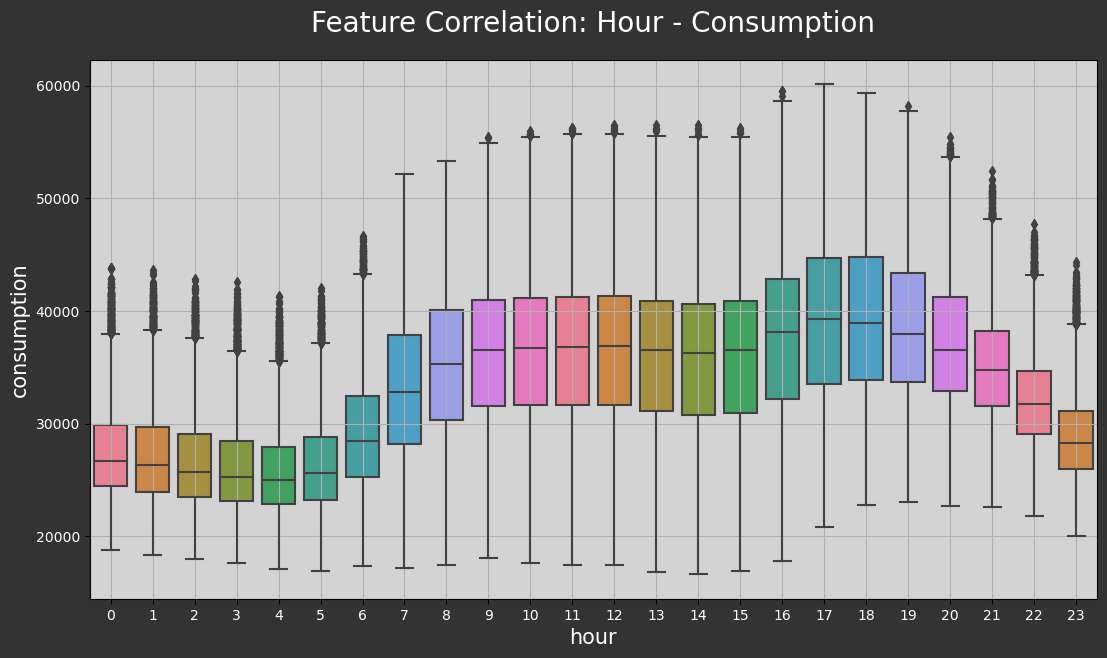

In [126]:
boxplot_correlation(df, 'hour', 'consumption', 
					palette = colors)

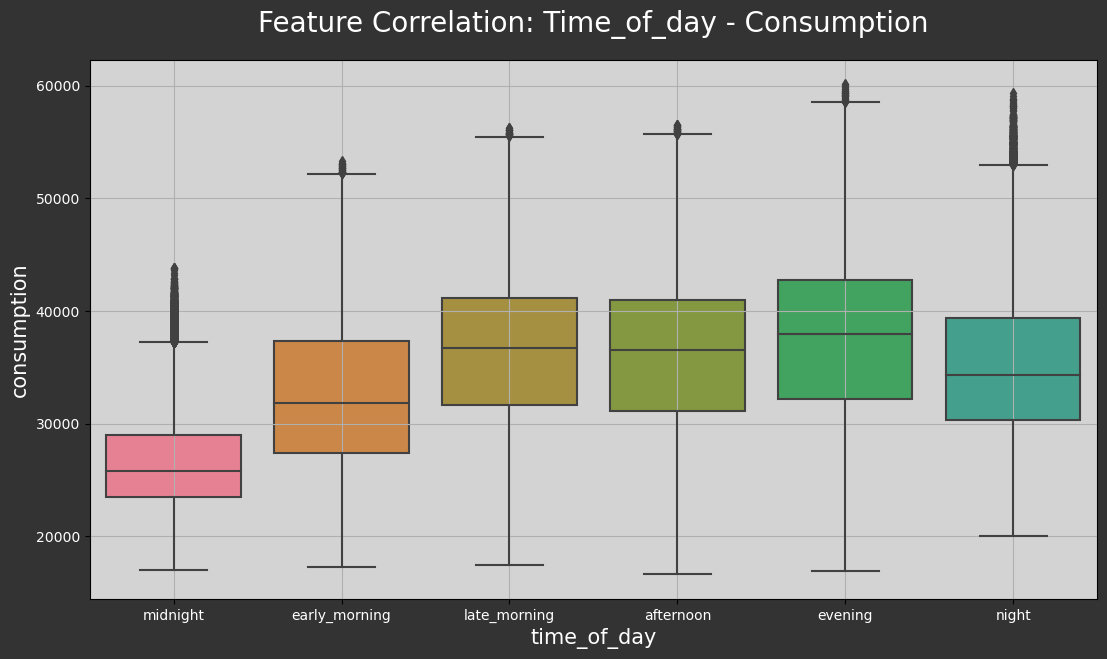

In [128]:
daytimes = ['midnight', 'early_morning', 'late_morning', 'afternoon', 
			'evening', 'night']

boxplot_correlation(df, 'time_of_day', 'consumption', 
					order = daytimes, palette = colors)

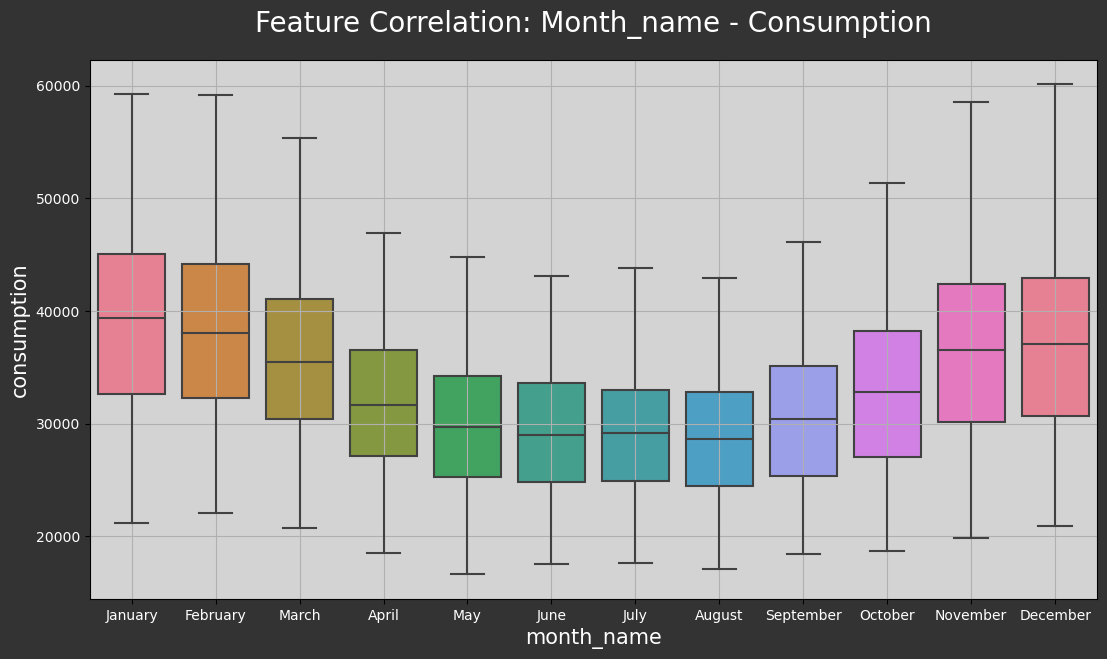

In [129]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
                  'August', 'September', 'October', 'November', 'December']

boxplot_correlation(df, 'month_name', 'consumption', 
					order = months, palette = colors)

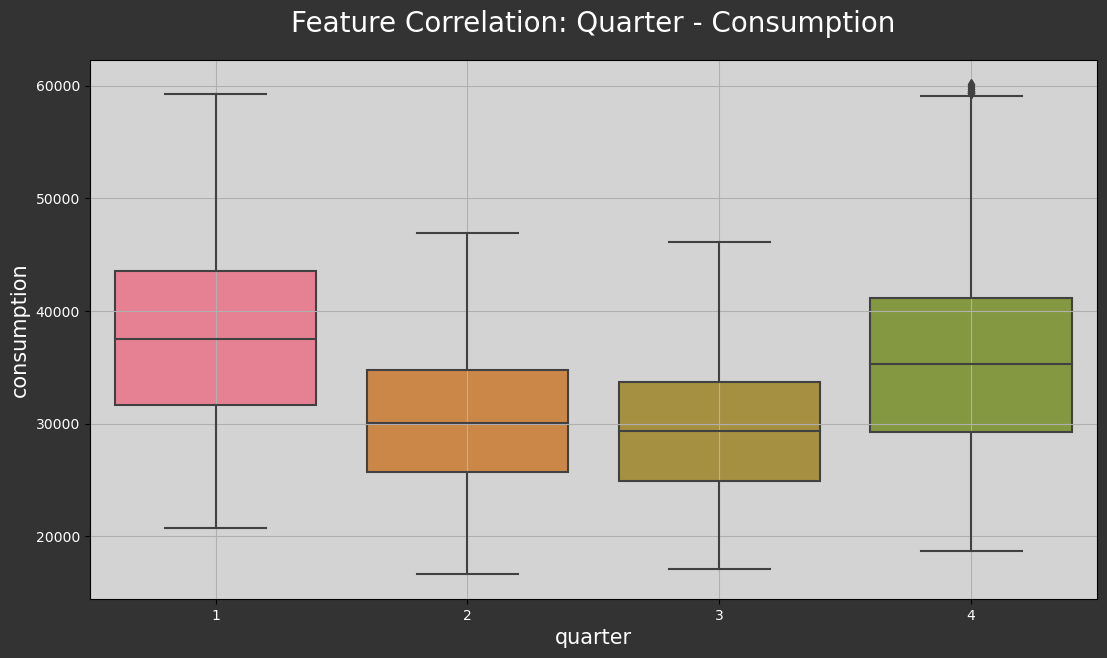

In [130]:
boxplot_correlation(df, 'quarter', 'consumption',
				   palette = colors)

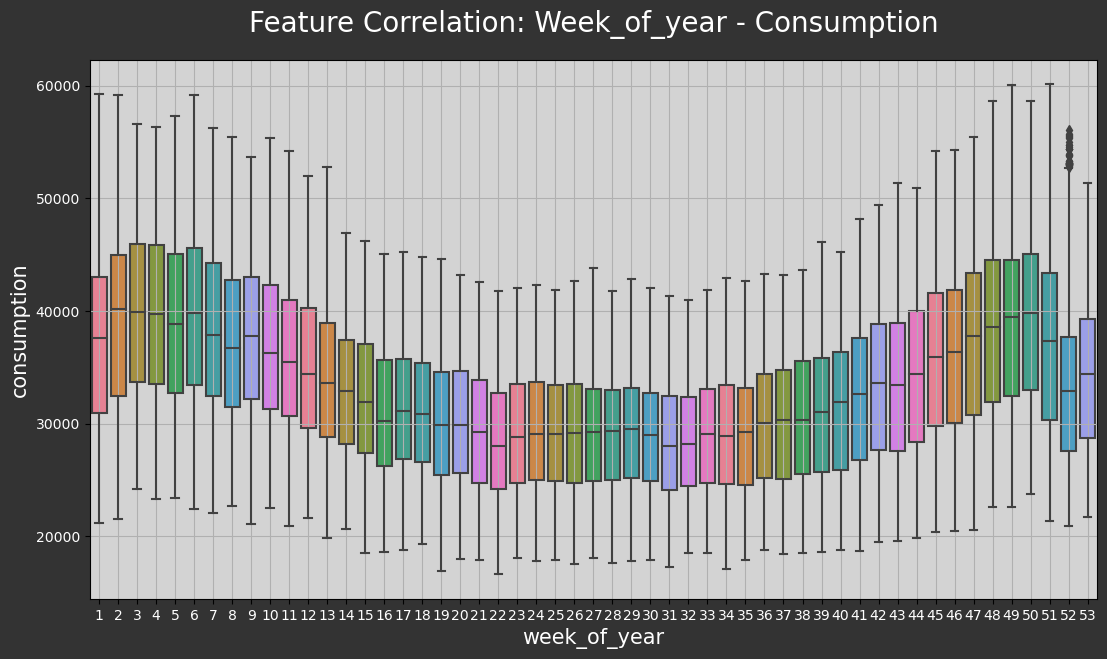

In [131]:
boxplot_correlation(df, 'week_of_year', 'consumption',
				   palette = colors)

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Converting `week_of_year` to float for model training**

In [132]:
df['week_of_year'] = df.week_of_year.astype(float)

<a name="lag_features"></a>

---

**Sections:**  ●  [Top](#top)  ●  [The Data](#data)  ●  [Feature Engineering](#features)  ●  [Investigating Correlation](#correlation)   ●  [Lag Features](#lag_features)   ●  [Splitting](#splitting)   ●  [The Model](#model)   ●  [Results with Traditional Split](#traditional_results)   ●  [Using Cross-Validation](#cross_validation)   ●  [Making Future Predictions](#future_predictions)  

---

<span style = 'background-color: purple; padding: 5px 5px 3px 5px; line-height: 1.5; color:white;border-radius: 3px;'><font size = 4>**Lag Features**</font></span>

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Forecasting Horizon & Lag Features**
* Lag Features: telling the model to look back into the past, and use the target value for that many days back as a new feature fed into the model
* in this case, it is a value from the energy usage column
* we are saving this column as a `dict` called `target_map`
* using 364 as the increment, because it is perfectly divisible by 7 and will line up days of the week
* the forecast horizon cannot extend farther than the shortest lag chosen
* using `map()` to map the values

In [133]:
def year_lags(df, target_column, lag_label_list):
	
	target_map = df[target_column].to_dict()
	inputs = lag_label_list.copy()
	
	for tup in inputs:
		df[tup[1]] = (df.index - pd.Timedelta(tup[0])).map(target_map)
	
	return df

In [134]:
lag_label_list = [('364 days', 'one_year'),
				  ('728 days', 'two_year'),
				  ('1092 days', 'three_year')]

In [135]:
df_lags = df.copy()
df_lags = year_lags(df_lags, 'consumption', lag_label_list)

In [136]:
missing_values(df_lags[['one_year', 'two_year', 'three_year']])

,column name,missing
0,one_year,18098
1,two_year,35380
2,three_year,52854


<a name="splitting"></a>

---

**Sections:**  ●  [Top](#top)  ●  [The Data](#data)  ●  [Feature Engineering](#features)  ●  [Investigating Correlation](#correlation)   ●  [Lag Features](#lag_features)   ●  [Splitting](#splitting)   ●  [The Model](#model)   ●  [Results with Traditional Split](#traditional_results)   ●  [Using Cross-Validation](#cross_validation)   ●  [Making Future Predictions](#future_predictions)  

---

<span style = 'background-color: purple; padding: 5px 5px 3px 5px; line-height: 1.5; color:white;border-radius: 3px;'><font size = 4>**Splitting the Data**</font></span>
* Because I noticed that I actually got better results training without the lag features added, I will be running each operation on both the data without lag features and with lag features for comparison.

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Traditional Train-Test Split**
* training data will the first 75% of the data
* test data will be everything the last 25% of the data

In [155]:
split_point = round(len(df) * .75)

In [156]:
train_data = df[: split_point]
test_data = df[split_point :]
train_data = pd.get_dummies(data=train_data, columns = ['time_of_day'])
test_data = pd.get_dummies(data=test_data, columns = ['time_of_day'])

In [157]:
train_data_lags = df_lags[: split_point]
test_data_lags = df_lags[split_point :]
train_data_lags = pd.get_dummies(data=train_data_lags, columns = ['time_of_day'])
test_data_lags = pd.get_dummies(data=test_data_lags, columns = ['time_of_day'])

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Checking the point at which the training and testing divide**

In [168]:
d(train_data.tail(1))
d(test_data.head(1))

,consumption,holiday,hour,weekday,weekday_name,month,month_name,quarter,year,week_of_year,day_of_year,time_of_day_afternoon,time_of_day_early_morning,time_of_day_evening,time_of_day_late_morning,time_of_day_midnight,time_of_day_night
datetime,,,,,,,,,,,,,,,,,
2019-07-06 12:00:00,27249,0,12,5,Saturday,7,July,3,2019,27,187,1,0,0,0,0,0


,consumption,holiday,hour,weekday,weekday_name,month,month_name,quarter,year,week_of_year,day_of_year,time_of_day_afternoon,time_of_day_early_morning,time_of_day_evening,time_of_day_late_morning,time_of_day_midnight,time_of_day_night
datetime,,,,,,,,,,,,,,,,,
2019-07-06 12:30:00,27055,0,12,5,Saturday,7,July,3,2019,27,187,1,0,0,0,0,0


<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Visualizing the Traditional Train-Test Split**

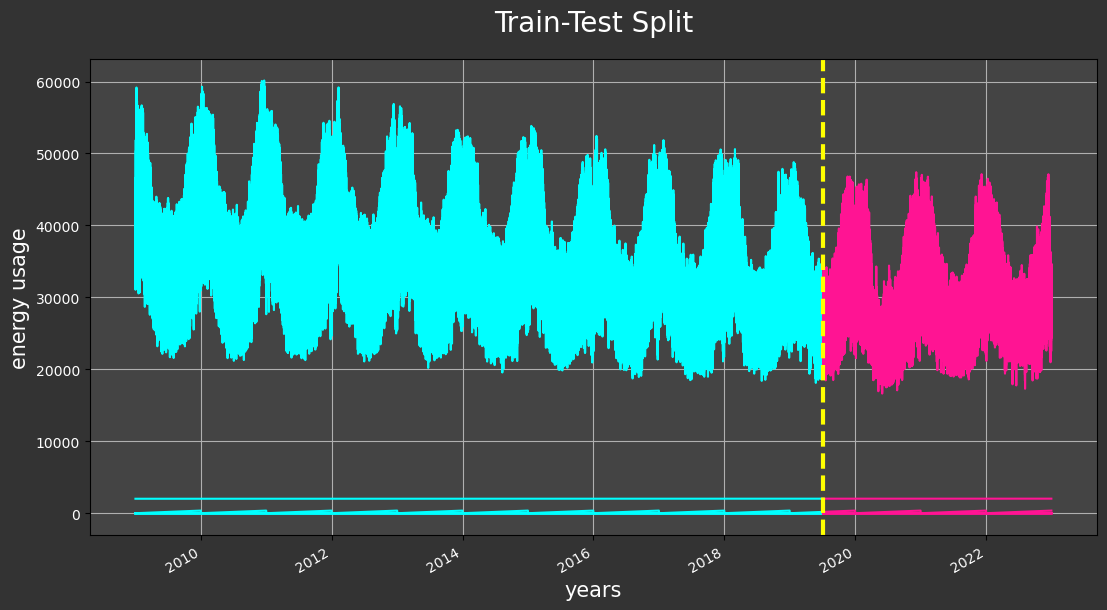

In [172]:
fig, ax = plt.subplots(figsize = (13, 7), facecolor = '#333333')
ax.set_facecolor('#444444')
train_data.plot(ax = ax, label = 'Training Data', color = 'cyan');
test_data.plot(ax = ax, label = 'Testing Data', color = 'deeppink');
ax.grid()
ax.axvline('2019-07-06', color = 'yellow', ls = '--', linewidth = 3)
plt.xlabel('years', color = 'white', fontsize = 15)
plt.ylabel('energy usage', color = 'white', fontsize = 15)
plt.xticks(color='white'); plt.yticks(color='white');
plt.title('Train-Test Split', fontsize = 20, pad = 20, color = 'white');
plt.legend().remove()

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Defining Features & Targets**

In [173]:
features = ['hour', 'weekday', 'month', 'quarter', 'year', 
			'week_of_year', 'day_of_year', 'time_of_day_afternoon', 
			'time_of_day_early_morning', 'time_of_day_evening', 
			'time_of_day_late_morning', 'time_of_day_midnight', 
			'time_of_day_night']

features_lags = ['hour', 'weekday', 'month', 'quarter', 'year', 
			'week_of_year', 'day_of_year', 'time_of_day_afternoon', 
			'time_of_day_early_morning', 'time_of_day_evening', 
			'time_of_day_late_morning', 'time_of_day_midnight', 
			'time_of_day_night', 'one_year', 'two_year', 'three_year']
							 
target = "consumption"

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Defining Training & Testing Data with Features**

In [174]:
train_in = train_data[features]
train_out = train_data[target]
test_in = test_data[features]
test_out = test_data[target]

In [175]:
train_in_lags = train_data_lags[features_lags]
train_out_lags = train_data_lags[target]
test_in_lags = test_data_lags[features_lags]
test_out_lags = test_data_lags[target]

<a name="model"></a>

---

**Sections:**  ●  [Top](#top)  ●  [The Data](#data)  ●  [Removing Outliers](#outliers)  ●  [Feature Engineering](#features)  ●  [Investigating Correlation](#correlation)   ●  [Lag Features](#lag_features)   ●  [Splitting](#splitting)   ●  [The Model](#model)   ●  [Results with Traditional Split](#traditional_results)   ●  [Using Cross-Validation](#cross_validation)   ●  [Making Future Predictions](#future_predictions)  

---

<span style = 'background-color: purple; padding: 5px 5px 3px 5px; line-height: 1.5; color:white;border-radius: 3px;'><font size = 4>**The XGBoost Regressor Model**</font></span>

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Creating the Model (without lags)**

In [180]:
xgb_regressor = XGBRegressor(n_estimators = 1200,
							 learning_rate = 0.012, 
							 early_stopping_rounds = 23)

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Fitting the Model (without lags)**

In [181]:
xgb_regressor.fit(train_in, train_out,
				 eval_set = [(train_in, train_out), 
							  (test_in, test_out)], verbose = 25)

[0]	validation_0-rmse:35068.46435	validation_1-rmse:29587.12720
[25]	validation_0-rmse:26018.01179	validation_1-rmse:21235.48885
[50]	validation_0-rmse:19337.02538	validation_1-rmse:15148.51055
[75]	validation_0-rmse:14411.06888	validation_1-rmse:10692.43309
[100]	validation_0-rmse:10787.75506	validation_1-rmse:7519.52345
[125]	validation_0-rmse:8131.03112	validation_1-rmse:5323.82623
[150]	validation_0-rmse:6192.47195	validation_1-rmse:3833.85620
[175]	validation_0-rmse:4791.75784	validation_1-rmse:2961.30137
[200]	validation_0-rmse:3789.02170	validation_1-rmse:2547.03297
[225]	validation_0-rmse:3086.91956	validation_1-rmse:2420.27304
[250]	validation_0-rmse:2602.61653	validation_1-rmse:2429.93979
[257]	validation_0-rmse:2496.84033	validation_1-rmse:2442.06684


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=23,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.012, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Fitting the Model (with lags)**

In [182]:
xgb_regressor_lags = XGBRegressor(n_estimators = 1200,
							 learning_rate = 0.012, 
							 early_stopping_rounds = 23)

In [183]:
xgb_regressor_lags.fit(train_in_lags, train_out_lags,
				 eval_set = [(train_in_lags, train_out_lags), 
							  (test_in_lags, test_out_lags)], 
				  verbose = 25)

[0]	validation_0-rmse:35067.37778	validation_1-rmse:29621.32089
[25]	validation_0-rmse:25992.89494	validation_1-rmse:21982.27167
[50]	validation_0-rmse:19296.64994	validation_1-rmse:16362.81470
[75]	validation_0-rmse:14362.19803	validation_1-rmse:12236.19017
[100]	validation_0-rmse:10732.97496	validation_1-rmse:9220.63188
[125]	validation_0-rmse:8075.19740	validation_1-rmse:7039.05742
[150]	validation_0-rmse:6141.15746	validation_1-rmse:5477.98424
[175]	validation_0-rmse:4744.45133	validation_1-rmse:4392.53113
[200]	validation_0-rmse:3752.23105	validation_1-rmse:3673.74192
[225]	validation_0-rmse:3063.21492	validation_1-rmse:3212.91990
[250]	validation_0-rmse:2594.90743	validation_1-rmse:2925.86404
[275]	validation_0-rmse:2282.94267	validation_1-rmse:2750.60546
[300]	validation_0-rmse:2073.32089	validation_1-rmse:2662.13021
[325]	validation_0-rmse:1937.22774	validation_1-rmse:2611.90552
[350]	validation_0-rmse:1836.60203	validation_1-rmse:2585.33120
[375]	validation_0-rmse:1762.79711	v

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=23,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.012, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Feature Importance (without lags)**

In [187]:
feature_importance = pd.DataFrame(data = xgb_regressor.feature_importances_,
									index = xgb_regressor.feature_names_in_,
									columns = ['importance'])

feature_importance = feature_importance[feature_importance.importance > 0.0005]

multi([(feature_importance.sort_values('importance', ascending = False), 
		'Feature Importance (no lags)'),
	  (feature_importance_lags.sort_values('importance', ascending = False), 
		'Feature Importance (with lags)')], precision = 4)

,importance
hour,0.3328
week_of_year,0.2212
day_of_year,0.1193
weekday,0.1191
year,0.1179
month,0.0498
time_of_day_afternoon,0.0147
time_of_day_evening,0.0127
time_of_day_late_morning,0.0125
,importance


<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Plotting Feature Importance**

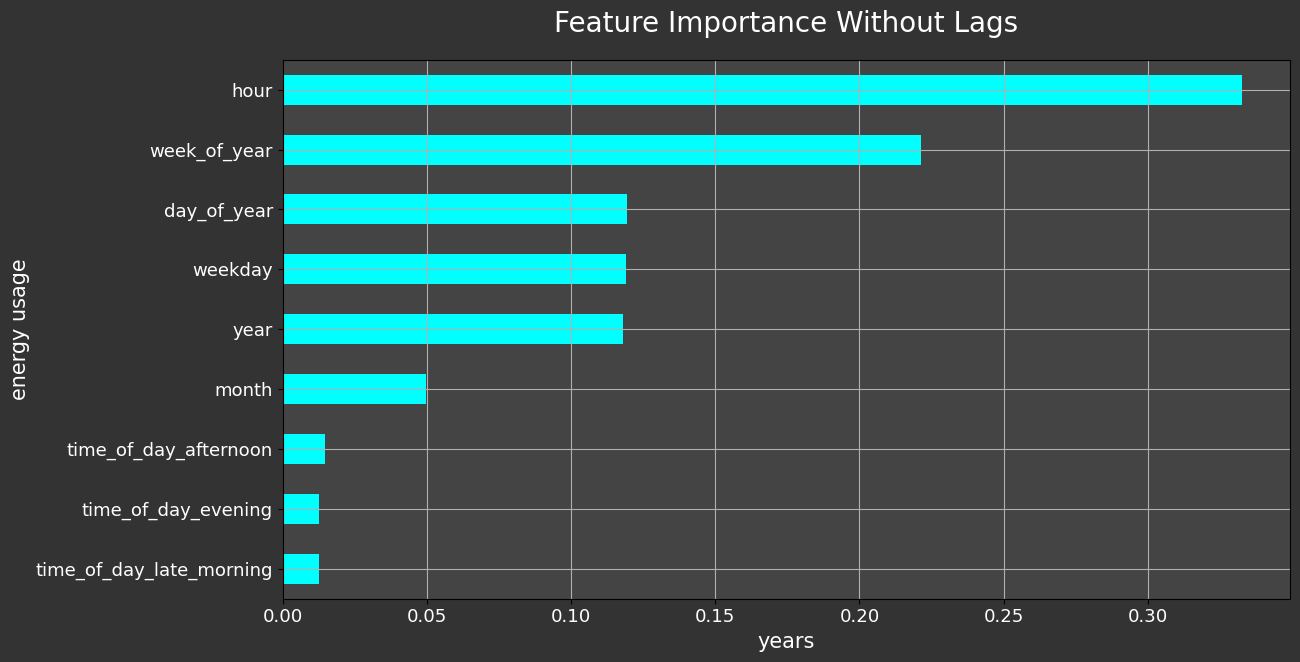

In [188]:
fig, ax = plt.subplots(figsize = (13, 7), facecolor = '#333333')
ax.set_facecolor('#444444')

feature_importance.sort_values('importance').plot(kind = 'barh', 
												  color = 'cyan', 
												  ax = ax)
ax.grid()
plt.xlabel('years', color = 'white', fontsize = 15)
plt.ylabel('energy usage', color = 'white', fontsize = 15)
plt.xticks(color='white', size = 13); plt.yticks(color='white', size = 13);
plt.title('Feature Importance Without Lags', fontsize = 20, pad = 20, color = 'white');
plt.legend().remove()

<a name="traditional_results"></a>

---

**Sections:**  ●  [Top](#top)  ●  [The Data](#data)  ●  [Feature Engineering](#features)  ●  [Investigating Correlation](#correlation)   ●  [Lag Features](#lag_features)   ●  [Splitting](#splitting)   ●  [The Model](#model)   ●  [Results with Traditional Split](#traditional_results)   ●  [Using Cross-Validation](#cross_validation)   ●  [Making Future Predictions](#future_predictions)  

---

<span style = 'background-color: purple; padding: 5px 5px 3px 5px; line-height: 1.5; color:white;border-radius: 3px;'><font size = 4>**Results with Traditional Train-Test Split**</font></span>
* Because there is no benefit to having the lag data added, for the remainder of the project, I will be working with only the data without lags added.

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Predicting with Test Data**

In [189]:
test_data['prediction'] = xgb_regressor.predict(test_in)

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Merging Predictions into Original DF**

In [190]:
df = df.merge(test_data['prediction'], 
			  how = 'left', 
			  left_index = True,
			  right_index = True)

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Plotting Predictions vs Original Data**

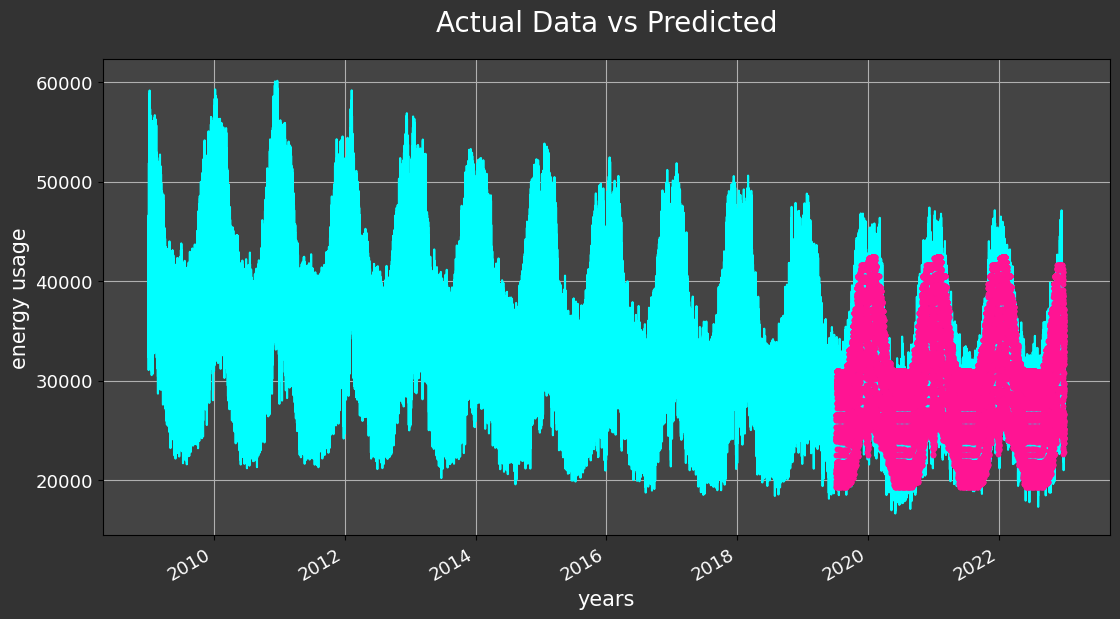

In [193]:
plt.figure(facecolor = '#333333');
ax = df['consumption'].plot(figsize = (13, 7), color = 'cyan');
ax.set_facecolor('#444444');
df['prediction'].plot(ax = ax, style = '.', color = 'deeppink');
plt.legend();
ax.grid()
plt.xlabel('years', color = 'white', fontsize = 15)
plt.ylabel('energy usage', color = 'white', fontsize = 15)
plt.xticks(color='white', size = 13); plt.yticks(color='white', size = 13);
plt.title('Train-Test Split', fontsize = 20, pad = 20, color = 'white');
plt.legend().remove()
ax.set_title('Actual Data vs Predicted', color = 'white', size = 20, pad = 20);

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Predictions vs Targets: One Week Excerpt**

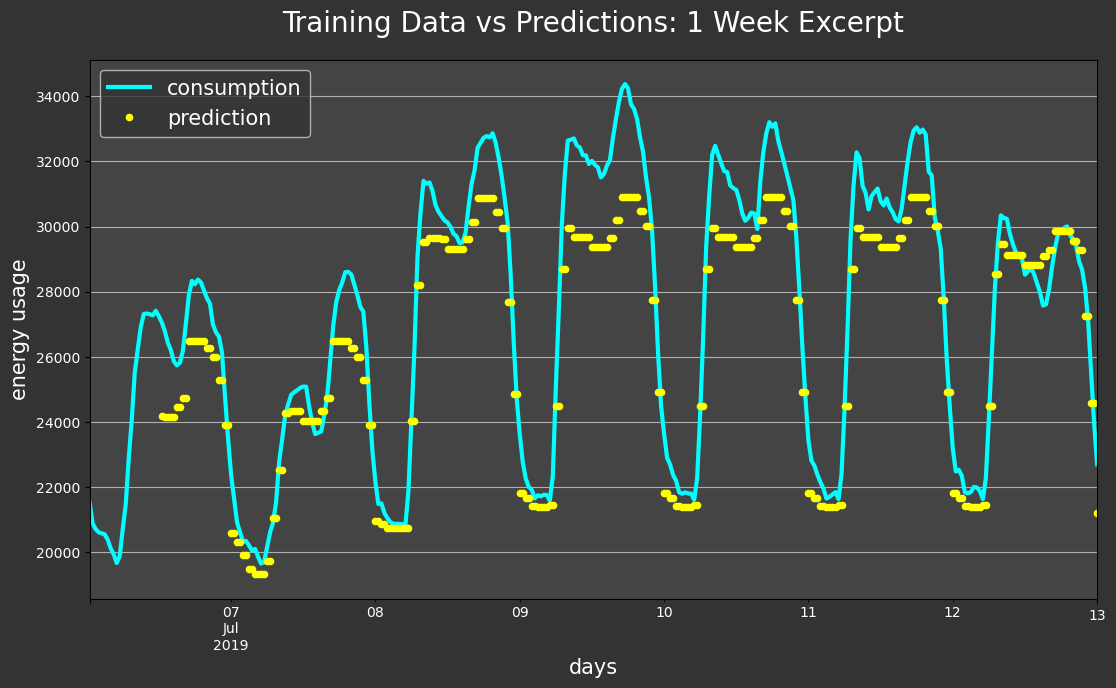

In [197]:
plt.figure(figsize = (13, 7), facecolor = '#333333')
ax = df.loc[(df.index > '2019-07-06') & (df.index <= '2019-07-13')]\
			['consumption'].plot(color = 'cyan', linewidth = 3);
df.loc[(df.index > '2019-07-06') & (df.index <= '2019-07-13')]\
			['prediction'].plot(style = '.', color = 'yellow', markersize = 9);
ax.set_facecolor('#444444')
plt.legend();
ax.grid()
plt.xlabel('days', color = 'white', fontsize = 15)
plt.ylabel('energy usage', color = 'white', fontsize = 15)
plt.tick_params(labelcolor = 'white', which = 'both')
plt.title('Training Data vs Predictions: 1 Week Excerpt', fontsize = 20, pad = 20, color = 'white');
plt.legend(fontsize = 15, labelcolor = 'white', facecolor = '#333333');

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Prediction Accuracy**

In [199]:
def get_accuracy(df, pred_col, actual_col):
	from sklearn.metrics import mean_squared_error
	df = df.copy()
	
	df['abs_acc'] = (1 - (abs(df[actual_col] - 
								   df[pred_col]) / df[actual_col])) * 100
	
	range_diff = np.max(df[actual_col]) - np.min(df[actual_col])
	
	df['rel_acc'] = (1 - (abs(df[actual_col] - 
								   df[pred_col]) / range_diff)) * 100 
	
	range_std = np.std(df[actual_col])
	
	df['sharpe'] = (abs(df[actual_col] - 
								   df[pred_col]) / range_std)
	
	rmse = np.sqrt(mean_squared_error(df[actual_col], 
										df[pred_col]))
	
	results = pd.Series([f"{rmse:,.2f}", 
						 f"{df['abs_acc'].mean():.2f}%",
						 f"{df['rel_acc'].mean():.2f}%",
						 f"{df['sharpe'].mean():.2f}"], 
						index = ['Average RMSE', 
								 'Average Absolute Accuracy', 
								 'Average Relative Accuracy',
								 'Average Sharpe Ratio'],
						name = "Resulting Metrics")
	
	see(results, 'Overall Metrics for Accuracy and Model Performance')

	return df

In [198]:
pred_actual = df.loc[df.prediction.notna()]

In [201]:
pred_actual = get_accuracy(pred_actual, 'consumption', 'prediction')

head_tail_horz(pred_actual[['consumption', 'prediction', 'abs_acc', 
							'rel_acc', 'sharpe']], 5, 'Predictions vs Actual Targets')

,Resulting Metrics
Average RMSE,"2,414.50"
Average Absolute Accuracy,93.58%
Average Relative Accuracy,91.91%
Average Sharpe Ratio,0.33


,consumption,prediction,abs_acc,rel_acc,sharpe
datetime,,,,,
2019-07-06,"27,055","24,169.05",88.06,87.51,0.51
2019-07-06,"26,790","24,147.77",89.06,88.56,0.47
2019-07-06,"26,434","24,147.77",90.53,90.10,0.40
2019-07-06,"26,204","24,147.77",91.48,91.10,0.36
2019-07-06,"25,862","24,147.77",92.90,92.58,0.30
,consumption,prediction,abs_acc,rel_acc,sharpe
datetime,,,,,
2022-12-31,"25,634","32,205.60",79.59,71.56,1.16
2022-12-31,"24,788","29,192.30",84.91,80.94,0.78


<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Plotting the Sharpe Ratio**

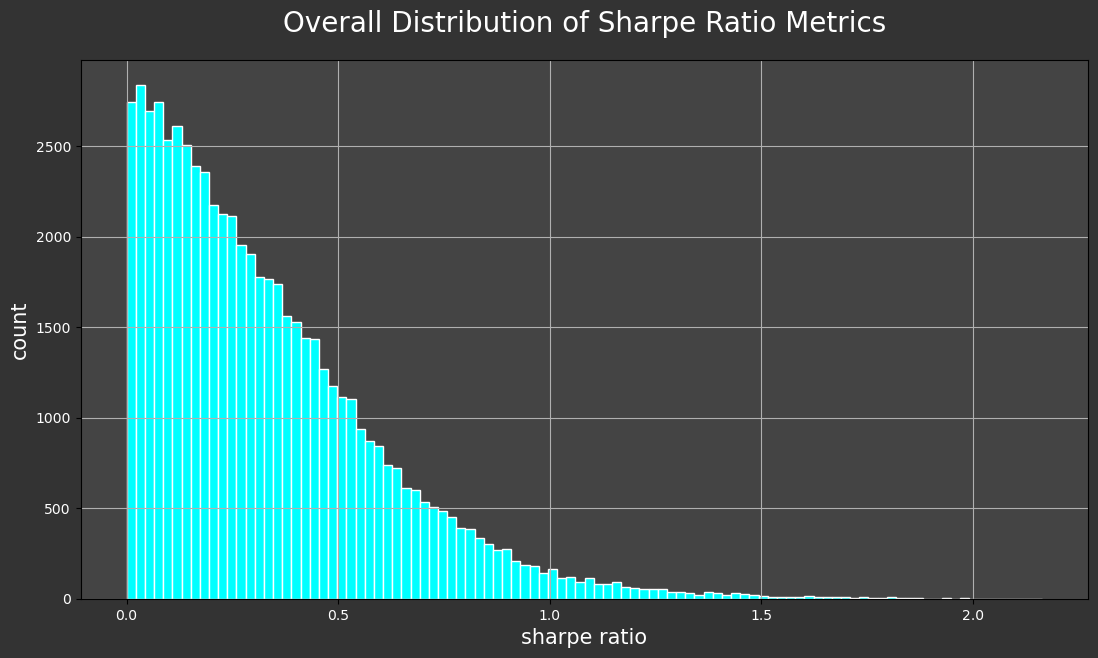

In [202]:
plt.figure(figsize = (13, 7), facecolor = '#333333')
ax = plt.axes()
pred_actual.sharpe.plot(kind="hist", 
						bins=100, 
						color = 'cyan',
						edgecolor = 'white',  
						ax = ax)
ax.set_facecolor('#444444')
plt.legend();
ax.grid()
plt.xlabel('sharpe ratio', color = 'white', fontsize = 15)
plt.ylabel('count', color = 'white', fontsize = 15)
plt.tick_params(labelcolor = 'white', which = 'both')
plt.title('Overall Distribution of Sharpe Ratio Metrics', 
		  fontsize = 20, pad = 20, color = 'white');
plt.legend().remove()

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Daily Error - Investigating the Days with the Highest and Lowest Error**

In [203]:
def get_daily_error(df, actual_col, pred_col, num_examples, 
					ascending = False):
	
	temp = df[[actual_col, pred_col]].copy()
	temp['date'] = temp.index.strftime('%A, %b %d, %Y')
	temp['error'] = np.abs(df[actual_col] - df[pred_col])
	
	results = temp.sort_values("error", ascending = ascending)
	
	error_style = {'error': [{'selector': '',
						      'props': [('color', 'red'),
										('font-weight', 'bold'),
										('padding-right', '15px'),
								        ('padding-left', '15px')]}],
				   'date': [{'selector': 'td',
						     'props': [('color', 'blue'),
									   ('font-weight', 'bold'),
									   ('padding-right', '15px'),
								       ('padding-left', '15px')]}],
				   'prediction': [{'selector': 'td',
						     'props': [('padding-right', '25px'),
								       ('padding-left', '15px')]}]}
	
	if ascending == True:
		pretty(f'Daily error for the {num_examples} days with the lowest error:',
			   fontsize = 4)
	else:
		pretty(f'Daily error for the {num_examples} days with the highest error:',
			   fontsize = 4)
	
	return results[['date', 
					'error', 
					pred_col, 
					actual_col]].head(num_examples).style.hide(axis='index')\
						.set_table_styles(error_style)\
						.format(precision=3, thousands=",")

In [204]:
get_daily_error(pred_actual, 'consumption', 'prediction', 10)

date,error,prediction,consumption
"Monday, Jan 03, 2022","12,227.672","38,637.672","26,410"
"Sunday, Dec 25, 2022","11,386.129","34,748.129","23,362"
"Monday, May 25, 2020","11,337.658","29,313.658","17,976"
"Monday, May 25, 2020","11,248.658","29,313.658","18,065"
"Monday, Jan 03, 2022","11,133.672","38,637.672","27,504"
"Sunday, Dec 25, 2022","11,090.129","34,748.129","23,658"
"Monday, May 25, 2020","10,898.234","29,617.234","18,719"
"Sunday, Dec 25, 2022","10,891.258","34,945.258","24,054"
"Monday, Apr 13, 2020","10,769.680","30,451.680","19,682"
"Monday, Apr 13, 2020","10,671.783","30,159.783","19,488"


In [230]:
get_daily_error(pred_actual, 'consumption', 'prediction', 10,
			   ascending = True)

date,error,prediction,consumption
"Monday, Oct 14, 2019",0.107,"25,882.107","25,882"
"Saturday, Dec 14, 2019",0.250,"26,106.250","26,106"
"Wednesday, Oct 13, 2021",0.395,"32,784.605","32,785"
"Tuesday, Feb 09, 2021",0.395,"40,235.605","40,236"
"Tuesday, Nov 26, 2019",0.443,"26,390.443","26,390"
"Friday, Aug 27, 2021",0.479,"28,798.521","28,799"
"Saturday, Oct 30, 2021",0.508,"23,858.508","23,858"
"Thursday, Dec 02, 2021",0.557,"31,655.443","31,656"
"Sunday, Jun 27, 2021",0.600,"20,580.600","20,580"
"Monday, Mar 14, 2022",0.686,"24,652.314","24,653"


<a name="cross_validation"></a>

---

**Sections:**  ●  [Top](#top)  ●  [The Data](#data)  ●  [Feature Engineering](#features)  ●  [Investigating Correlation](#correlation)   ●  [Lag Features](#lag_features)   ●  [Splitting](#splitting)   ●  [The Model](#model)   ●  [Results with Traditional Split](#traditional_results)   ●  [Using Cross-Validation](#cross_validation)   ●  [Making Future Predictions](#future_predictions)  

---

<span style = 'background-color: purple; padding: 5px 5px 3px 5px; line-height: 1.5; color:white;border-radius: 3px;'><font size = 4>**Training the Model Using Cross Validation**</font></span>

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**What is Cross Validation?**
* using sklearn `TimeSeriesSplit()`
* test size is 1 year of hourly records
* a gap of 24 puts a 1 day gap between the end of a training set and beginning of a test set
* must be sure time series data is sorted so that the time series split will work

In [205]:
time_series_split = TimeSeriesSplit(n_splits = 5,
								    test_size = (24 * 365 * 1),
								    gap = 24)

df = df.sort_index()

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**This creates a time series split generator object**
* this object will be applied across the data
* it will loop over the data for as many splits as are passed

In [206]:
time_series_split

TimeSeriesSplit(gap=24, max_train_size=None, n_splits=5, test_size=8760)

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Visualizing the `TimeSeriesSplit()` process**
	
* for each fold, the model goes back and tests the testing data in 1 year increments, independently from the rest of the testing data
* this is a very good approach when the dataset has a large number of records

In [207]:
for train_index, validation_index in time_series_split.split(df):
	break
pretty(train_index, 'Indices of training data:')
pretty(validation_index, 'Indices of validation data:'); sp()

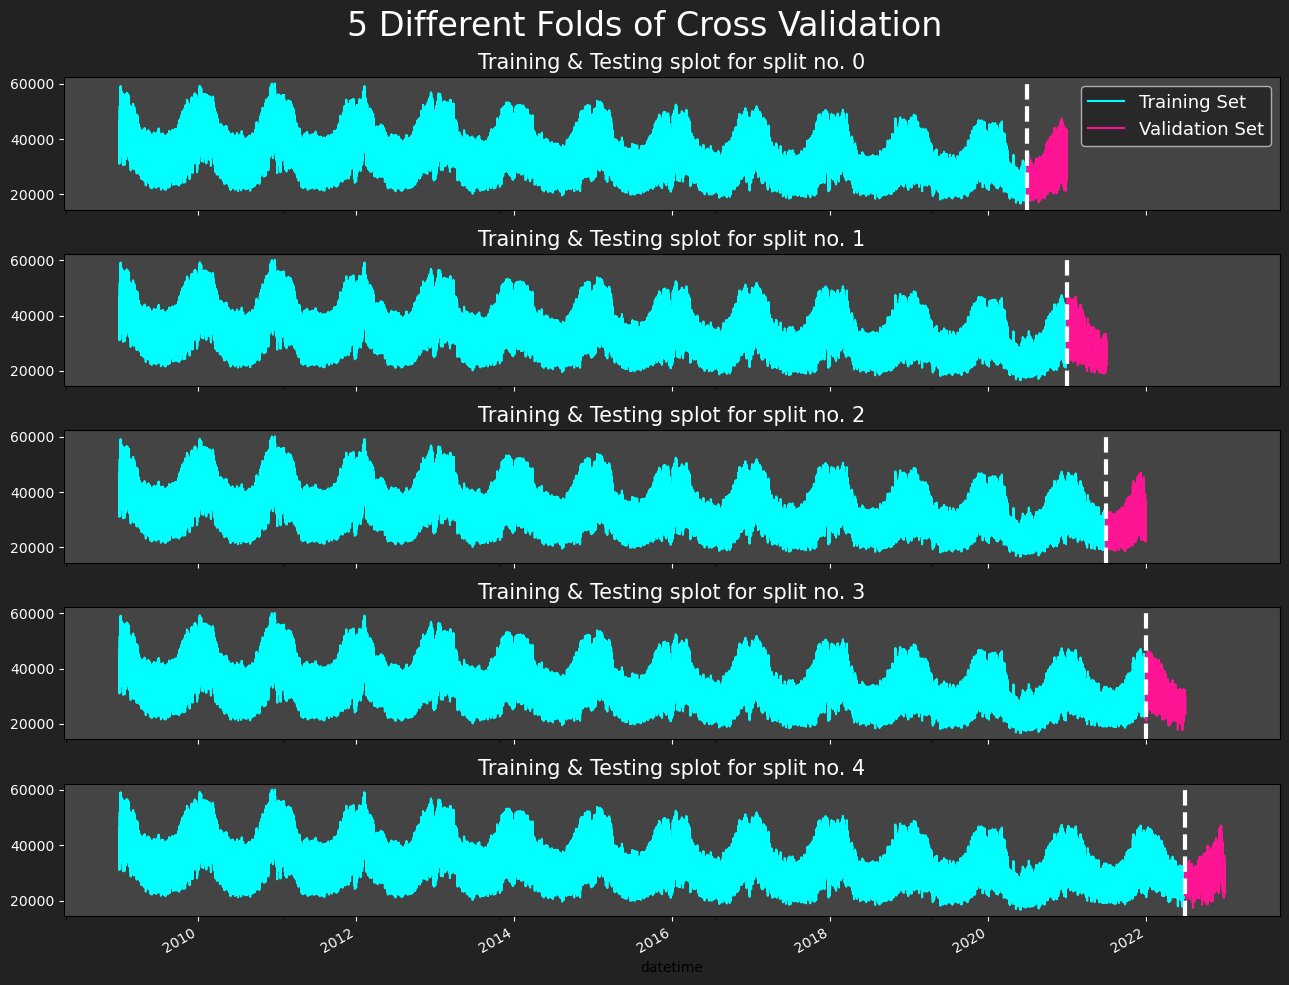

In [231]:
fig, axs = plt.subplots(5, 1, figsize = (13, 10),
					   sharex = True, facecolor = "#222222")

split = 0
for train_index, validation_index in time_series_split.split(df):
	training = df.iloc[train_index]
	validation = df.iloc[validation_index]
	
	ax = axs[split]
	ax.set_facecolor('#444444')
	ax.set_title(f'Training & Testing splot for split no. {split}', 
				 fontsize = 15, color = 'white')
	ax.tick_params(color = 'white', labelcolor = 'white')

	training['consumption'].plot(ax = ax,
							label = 'Training Set',
							color = 'cyan')
	validation['consumption'].plot(ax = ax,
							label = 'Validation Set',
							  color = 'deeppink')

	axs[split].axvline(validation.index.min(), 
					  color = 'white', ls = "--", linewidth = 3)
	
	axs[0].legend(fontsize=13, facecolor = '#222222', labelcolor = 'white')

	split += 1

plt.suptitle('5 Different Folds of Cross Validation', color = 'white', fontsize = 24)
plt.tight_layout()

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Training with Cross Validation**
* this will repeat the steps above in order to now train with cross validation and the `TimeSeriesSplit()` method

In [213]:
def cross_validation_train(df, target_column,
							lags = False, lag_label_list = None, 
							splits = 5, test_size = (24 * 365 * 1),
							gap = 24, base_score = 0.5, booster = 'gbtree',
							n_estimators = 1200, early_stopping_rounds = 50,
							objective = 'reg:squarederror', max_depth = 3,
							learning_rate = 0.01, verbose = 25):
	
	from sklearn.metrics import mean_squared_error
	from sklearn.model_selection import TimeSeriesSplit
	
	# ................ Establishing Features & Targets ................ #
	
	df = featurize_datetime_index(df)
	target = target_column
	
	# ................ Lag Features & Feature Cleanup ................. #
	
	if lags:
		df = year_lags(df, target_column, lag_label_list)
		features = list(df.columns)

	else:
		features = list(df.columns)

	features.remove('weekday_name')
	features.remove('month_name')
	features.remove('time_of_day')
	features.remove(target)
		
	# ................. Correcting Datatypes for Model ................ #
		
	df['week_of_year'] = df.week_of_year.astype(float)
	
	# .................. Setting Up Cross-Validation .................. #
		
	split = 1
	prediction_log = []
	target_log = []
	rmse_log = []
		
	df = df.sort_index()
	time_series_split = TimeSeriesSplit(n_splits = splits,
								    test_size = test_size,
								    gap = gap)
	
	# ............... Running Cross-Validation Training ............... #
	
	for train_index, validation_index in time_series_split.split(df):
		pretty(f'Training split:  {split} of {splits}')
		training = df.iloc[train_index]
		validation = df.iloc[validation_index]
		
		train_in = training[features]
		train_out = training[target]
		test_in = validation[features]
		test_out = validation[target]
		
		model = XGBRegressor(base_score = base_score,
							   booster = booster,
							   n_estimators = n_estimators,
							   early_stopping_rounds = early_stopping_rounds,
							   objective = objective,
							   max_depth = max_depth,
							   learning_rate = learning_rate)
		

		model.fit(train_in, train_out,
				 eval_set = [(train_in, train_out), 
							  (test_in, test_out)], 
				  verbose = verbose)
		
		targets = list(test_out)
		target_log += targets
		
		prediction = model.predict(test_in)
		prediction_log += list(prediction)
		
		rmse = np.sqrt(mean_squared_error(test_out, prediction))
		rmse_log.append((f'split {split}', rmse))
		
		split += 1
		
	# ............. Compiling Training & Testing Results .............. #
		
	results = pd.DataFrame(pd.concat([pd.Series(prediction_log), 
									  pd.Series(target_log)],
									 axis = 1))
	results.columns = ['prediction', 'actual']
	
	pred_actual = get_accuracy(results, 'actual', 'prediction')
	
	print('')
	
	head_tail_horz(pred_actual[['actual', 'prediction', 'abs_acc', 
							'rel_acc', 'sharpe']], 5, 'Predictions vs Actual Targets')
	
	return pred_actual, rmse_log

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Cross-Validation Results without Lag Features**

In [214]:
cross_results, rmses = cross_validation_train(df, 
									   target_column = "consumption",
									   learning_rate = 0.012, 
									   verbose = 500,
									   splits = 16)

[0]	validation_0-rmse:36927.43252	validation_1-rmse:34875.18364
[500]	validation_0-rmse:2056.87214	validation_1-rmse:2423.05766
[1000]	validation_0-rmse:1676.66795	validation_1-rmse:2181.13980
[1199]	validation_0-rmse:1616.77561	validation_1-rmse:2155.05839


[0]	validation_0-rmse:36775.76007	validation_1-rmse:32375.93347
[265]	validation_0-rmse:3149.83870	validation_1-rmse:3050.08925


[0]	validation_0-rmse:36479.99831	validation_1-rmse:33557.74521
[298]	validation_0-rmse:2863.89178	validation_1-rmse:2735.91368


[0]	validation_0-rmse:36295.33002	validation_1-rmse:32125.01992
[500]	validation_0-rmse:2137.87922	validation_1-rmse:2715.88639
[1000]	validation_0-rmse:1753.45240	validation_1-rmse:2321.19621
[1199]	validation_0-rmse:1693.75240	validation_1-rmse:2266.00976


[0]	validation_0-rmse:36049.16304	validation_1-rmse:32516.82046
[281]	validation_0-rmse:3059.10355	validation_1-rmse:3166.45254


[0]	validation_0-rmse:35853.96617	validation_1-rmse:31558.53324
[500]	validation_0-rmse:2192.45384	validation_1-rmse:2735.75052
[1000]	validation_0-rmse:1807.99360	validation_1-rmse:2231.06479
[1199]	validation_0-rmse:1746.01944	validation_1-rmse:2185.40512


[0]	validation_0-rmse:35629.26492	validation_1-rmse:32723.94519
[500]	validation_0-rmse:2209.88738	validation_1-rmse:2666.12457
[803]	validation_0-rmse:1906.31098	validation_1-rmse:2620.93845


[0]	validation_0-rmse:35484.56719	validation_1-rmse:30590.92882
[500]	validation_0-rmse:2238.18373	validation_1-rmse:2665.97085
[1000]	validation_0-rmse:1874.88304	validation_1-rmse:2380.88144
[1199]	validation_0-rmse:1815.11051	validation_1-rmse:2338.74912


[0]	validation_0-rmse:35256.84386	validation_1-rmse:31274.43857
[291]	validation_0-rmse:3042.73232	validation_1-rmse:3021.40147


[0]	validation_0-rmse:35080.13209	validation_1-rmse:30334.97187
[500]	validation_0-rmse:2293.31344	validation_1-rmse:2368.77382
[1000]	validation_0-rmse:1929.70739	validation_1-rmse:1904.35239
[1199]	validation_0-rmse:1875.09340	validation_1-rmse:1853.25663


[0]	validation_0-rmse:34879.05495	validation_1-rmse:28467.95624
[214]	validation_0-rmse:4217.73427	validation_1-rmse:3978.68606


[0]	validation_0-rmse:34628.76251	validation_1-rmse:28969.99048
[500]	validation_0-rmse:2316.41624	validation_1-rmse:2452.28254
[828]	validation_0-rmse:2030.48465	validation_1-rmse:2354.46986


[0]	validation_0-rmse:34410.39062	validation_1-rmse:30310.69798
[407]	validation_0-rmse:2547.65380	validation_1-rmse:2682.01408


[0]	validation_0-rmse:34257.96348	validation_1-rmse:29340.27107
[500]	validation_0-rmse:2362.09599	validation_1-rmse:1989.56895
[607]	validation_0-rmse:2223.56214	validation_1-rmse:2001.37904


[0]	validation_0-rmse:34081.45769	validation_1-rmse:30150.75685
[460]	validation_0-rmse:2437.94536	validation_1-rmse:2518.15912


[0]	validation_0-rmse:33944.73814	validation_1-rmse:29491.10969
[382]	validation_0-rmse:2668.21192	validation_1-rmse:2609.05645


,Resulting Metrics
Average RMSE,"2,582.19"
Average Absolute Accuracy,93.57%
Average Relative Accuracy,93.70%
Average Sharpe Ratio,0.33


,actual,prediction,abs_acc,rel_acc,sharpe
0,"41,297","44,150.49",93.54,90.99,0.46
1,"44,813","44,150.49",98.50,97.91,0.11
2,"46,139","45,633.64",98.89,98.40,0.08
3,"45,716","45,633.64",99.82,99.74,0.01
4,"45,342","45,633.64",99.36,99.08,0.05
,actual,prediction,abs_acc,rel_acc,sharpe
140155,"25,634","32,433.49",79.04,78.52,1.11
140156,"24,788","29,763.41",83.28,84.29,0.81
140157,"24,365","29,763.41",81.86,82.95,0.88
140158,"24,766","27,849.91",88.93,90.26,0.50


<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Cross-Validation Results with Lag Features**

In [216]:
cross_results_lags, rmses_lags = cross_validation_train(df,
									   target_column = "consumption",
									   lags = True,
									   lag_label_list = lag_label_list,
									   learning_rate = 0.012, 
									   verbose = 500,
									   splits = 16)

[0]	validation_0-rmse:36925.12428	validation_1-rmse:34888.08778
[500]	validation_0-rmse:2037.49828	validation_1-rmse:2026.48655
[576]	validation_0-rmse:1964.88895	validation_1-rmse:2029.35903


[0]	validation_0-rmse:36773.31063	validation_1-rmse:32394.96397
[335]	validation_0-rmse:2386.18647	validation_1-rmse:1923.99288


[0]	validation_0-rmse:36477.26414	validation_1-rmse:33584.40726
[444]	validation_0-rmse:2104.36729	validation_1-rmse:2129.39891


[0]	validation_0-rmse:36292.39954	validation_1-rmse:32157.17855
[500]	validation_0-rmse:2046.95073	validation_1-rmse:2450.85211
[902]	validation_0-rmse:1815.59204	validation_1-rmse:2399.96702


[0]	validation_0-rmse:36046.01723	validation_1-rmse:32549.80008
[500]	validation_0-rmse:2064.69275	validation_1-rmse:2385.32174
[1000]	validation_0-rmse:1794.49164	validation_1-rmse:2315.57542
[1194]	validation_0-rmse:1740.22213	validation_1-rmse:2305.69089


[0]	validation_0-rmse:35850.48363	validation_1-rmse:31592.50643
[500]	validation_0-rmse:2095.36822	validation_1-rmse:2027.17829
[504]	validation_0-rmse:2090.82782	validation_1-rmse:2024.67160


[0]	validation_0-rmse:35625.58122	validation_1-rmse:32765.45789
[500]	validation_0-rmse:2089.91556	validation_1-rmse:2825.18626
[548]	validation_0-rmse:2048.50601	validation_1-rmse:2831.43948


[0]	validation_0-rmse:35480.78265	validation_1-rmse:30627.60853
[412]	validation_0-rmse:2209.38032	validation_1-rmse:2202.98109


[0]	validation_0-rmse:35252.84829	validation_1-rmse:31312.27241
[369]	validation_0-rmse:2293.48245	validation_1-rmse:2485.35647


[0]	validation_0-rmse:35075.91026	validation_1-rmse:30377.44317
[500]	validation_0-rmse:2132.74711	validation_1-rmse:1835.06696
[748]	validation_0-rmse:1989.27927	validation_1-rmse:1819.15242


[0]	validation_0-rmse:34874.70089	validation_1-rmse:28512.73610
[261]	validation_0-rmse:2895.43167	validation_1-rmse:2931.84616


[0]	validation_0-rmse:34623.79921	validation_1-rmse:28973.77077
[400]	validation_0-rmse:2271.53341	validation_1-rmse:2734.28776


[0]	validation_0-rmse:34405.31749	validation_1-rmse:30354.22325
[400]	validation_0-rmse:2289.59348	validation_1-rmse:3920.04580


[0]	validation_0-rmse:34252.93483	validation_1-rmse:29339.39192
[495]	validation_0-rmse:2193.78422	validation_1-rmse:1936.44759


[0]	validation_0-rmse:34076.15009	validation_1-rmse:30173.91135
[500]	validation_0-rmse:2186.48824	validation_1-rmse:2422.19548
[813]	validation_0-rmse:2021.39231	validation_1-rmse:2313.93976


[0]	validation_0-rmse:33939.52789	validation_1-rmse:29495.56077
[500]	validation_0-rmse:2189.84373	validation_1-rmse:2304.33924
[977]	validation_0-rmse:1978.42327	validation_1-rmse:2270.01215


,Resulting Metrics
Average RMSE,"2,411.87"
Average Absolute Accuracy,93.83%
Average Relative Accuracy,94.32%
Average Sharpe Ratio,0.29


,actual,prediction,abs_acc,rel_acc,sharpe
0,"41,297","43,600.54",94.72,92.88,0.36
1,"44,813","45,461.97",98.57,98.00,0.10
2,"46,139","46,121.54",99.96,99.95,0.00
3,"45,716","45,878.23",99.65,99.50,0.03
4,"45,342","45,525.46",99.60,99.43,0.03
,actual,prediction,abs_acc,rel_acc,sharpe
140155,"25,634","28,081.06",91.29,92.44,0.38
140156,"24,788","26,979.71",91.88,93.23,0.34
140157,"24,365","26,686.66",91.30,92.83,0.36
140158,"24,766","25,165.46",98.41,98.77,0.06


<a name="future_predictions"></a>

---

**Sections:**  ●  [Top](#top)  ●  [The Data](#data)  ●  [Feature Engineering](#features)  ●  [Investigating Correlation](#correlation)   ●  [Lag Features](#lag_features)   ●  [Splitting](#splitting)   ●  [The Model](#model)   ●  [Results with Traditional Split](#traditional_results)   ●  [Using Cross-Validation](#cross_validation)   ●  [Making Future Predictions](#future_predictions)  

---

<span style = 'background-color: purple; padding: 5px 5px 3px 5px; line-height: 1.5; color:white;border-radius: 3px;'><font size = 4>**Predicting into the Future**</font></span>

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**1. Retrain Model with All Training Data**

In [218]:
df = data.copy()

In [219]:
def future_predicting_model(df, target_column, 
						   lags = False, 
						   lag_label_list = None, 
						   base_score = 0.5,
						   booster = 'gbtree',
						   n_estimators = 500,
						   early_stopping_rounds = 50,
						   objective = 'reg:squarederror',
						   max_depth = 3,
						   learning_rate = 0.012, 
						   verbose = 250):
	
	from sklearn.metrics import mean_squared_error
	from sklearn.model_selection import TimeSeriesSplit
	
	# ................ Establishing Features & Targets ................ #
	
	df = featurize_datetime_index(df)
	target = target_column
	
	# ................ Lag Features & Feature Cleanup ................. #

	if lags:
		df = year_lags(df, target_column, lag_label_list)
		features = list(df.columns)
		features.remove('weekday_name')
		features.remove('month_name')
		features.remove('time_of_day')
		features.remove(target)
	else:
		features = list(df.columns)
		features.remove('weekday_name')
		features.remove('month_name')
		features.remove('time_of_day')
		features.remove(target)
		
	# ................. Correcting Datatypes for Model ................ #
		
	df['week_of_year'] = df.week_of_year.astype(float)
	
	input_data = df[features]
	target_data = df[target_column]
	
	model = XGBRegressor(base_score = base_score,
					   booster = booster,
					   n_estimators = n_estimators,
					   early_stopping_rounds = early_stopping_rounds,
					   objective = objective,
					   max_depth = max_depth,
					   learning_rate = learning_rate)
	
	trained_model = model.fit(input_data, target_data,
							 eval_set = [(input_data, target_data)],
							 verbose = verbose)
	
	return trained_model

In [220]:
trained_model = future_predicting_model(df, 
										'consumption', 
										lags = True,
									    lag_label_list = lag_label_list)

[0]	validation_0-rmse:33789.62223
[250]	validation_0-rmse:3052.85375
[499]	validation_0-rmse:2203.62563


<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**2. Create an empty dataframe for the date range to predict**
* Starting from the end of the input data
* Predicting almost 1 year into the future
* Frequency will be 1 hour, just like the input data frequency

In [221]:
df.index.max()

Timestamp('2022-12-31 23:30:00')

In [222]:
prediction_range = pd.date_range('2023-01-01', '2024-01-01',
								freq = '1h')

see(prediction_range[0:6], "First rows of prediction df")

,0
2023-01-01 00:00:00,2023-01-01 00:00:00
2023-01-01 01:00:00,2023-01-01 01:00:00
2023-01-01 02:00:00,2023-01-01 02:00:00
2023-01-01 03:00:00,2023-01-01 03:00:00
2023-01-01 04:00:00,2023-01-01 04:00:00
2023-01-01 05:00:00,2023-01-01 05:00:00


In [223]:
future_predictions_df = pd.DataFrame(index = prediction_range)
future_predictions_df['in_future'] = True
orig = df.copy()
orig['in_future'] = False
orig_plus_future = pd.concat([orig, future_predictions_df])

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**3. Combining the Past Data with Future**
* Adding the datetime and lag features
* Pulling out just the records that need predictions, `future_predictions`
* Removing from features the columns the model cannot or should not work with

In [224]:
orig_plus_future = featurize_datetime_index(orig_plus_future)
orig_plus_future = year_lags(orig_plus_future, 
							 target_column = "consumption", 
							 lag_label_list = lag_label_list)

In [225]:
features = list(orig_plus_future.columns)
features.remove('weekday_name')
features.remove('month_name')
features.remove('time_of_day')
features.remove('consumption')
features.remove('in_future')

In [226]:
future_predictions = orig_plus_future.query('in_future').copy()
head_tail_horz(future_predictions, 5, 'DF for Future Predictions')

,consumption,holiday,in_future,hour,weekday,weekday_name,month,month_name,quarter,year,week_of_year,day_of_year,time_of_day,one_year,two_year,three_year
2023-01-01,nan,nan,True,0,6,Sunday,1,January,1,"2,023",52,1,midnight,"23,687.00","27,106.00","25,639.00"
2023-01-01,nan,nan,True,1,6,Sunday,1,January,1,"2,023",52,1,midnight,"24,011.00","26,884.00","25,623.00"
2023-01-01,nan,nan,True,2,6,Sunday,1,January,1,"2,023",52,1,midnight,"23,108.00","25,666.00","24,789.00"
2023-01-01,nan,nan,True,3,6,Sunday,1,January,1,"2,023",52,1,midnight,"23,134.00","25,383.00","23,508.00"
2023-01-01,nan,nan,True,4,6,Sunday,1,January,1,"2,023",52,1,midnight,"23,177.00","24,916.00","23,494.00"
,consumption,holiday,in_future,hour,weekday,weekday_name,month,month_name,quarter,year,week_of_year,day_of_year,time_of_day,one_year,two_year,three_year
2023-12-31,nan,nan,True,20,6,Sunday,12,December,4,"2,023",52,365,night,nan,"29,859.00","36,686.00"
2023-12-31,nan,nan,True,21,6,Sunday,12,December,4,"2,023",52,365,night,nan,"27,706.00","33,733.00"
2023-12-31,nan,nan,True,22,6,Sunday,12,December,4,"2,023",52,365,night,nan,"26,569.00","30,963.00"
2023-12-31,nan,nan,True,23,6,Sunday,12,December,4,"2,023",52,365,night,nan,"25,540.00","27,874.00"


In [227]:
future_predictions = future_predictions[features]
future_predictions['week_of_year'] = future_predictions['week_of_year'].astype(float)

In [228]:
future_predictions['predictions'] = trained_model.predict(future_predictions[features])

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**4. Plotting the Prediction Results**

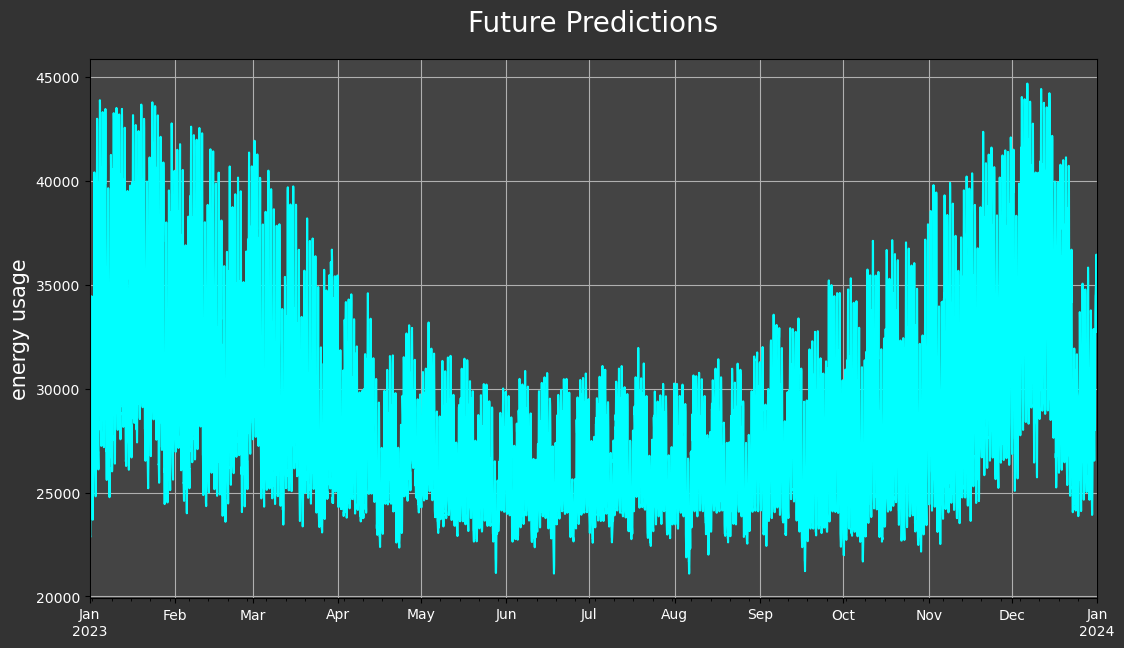

In [229]:
plt.figure(figsize = (13, 7), facecolor = '#333333')
ax = plt.axes()
future_predictions['predictions'].plot(ax = ax, color = 'cyan')
ax.set_facecolor('#444444')
ax.grid()
plt.xlabel('', color = 'white', fontsize = 15)
plt.ylabel('energy usage', color = 'white', fontsize = 15)
plt.tick_params(labelcolor = 'white', which = 'both')
plt.title('Future Predictions', 
		  fontsize = 20, pad = 20, color = 'white');
plt.legend().remove()

---

**Sections:**  ●  [Top](#top)  ●  [The Data](#data)  ●  [Feature Engineering](#features)  ●  [Investigating Correlation](#correlation)   ●  [Lag Features](#lag_features)   ●  [Splitting](#splitting)   ●  [The Model](#model)   ●  [Results with Traditional Split](#traditional_results)   ●  [Using Cross-Validation](#cross_validation)   ●  [Making Future Predictions](#future_predictions)  

---